本文来自 [Bubble sheet multiple choice scanner and test grader using OMR, Python and OpenCV](https://www.pyimagesearch.com/2016/10/03/bubble-sheet-multiple-choice-scanner-and-test-grader-using-omr-python-and-opencv/)

本文介绍如何使用计算机视觉和图像处理技术来实现气泡纸测试扫描仪和评分器（a bubble sheet test scanner and grader），提供几个考试成绩样本来测试OMR系统，最后讨论了当前气泡扫描仪系统的一些缺点，以及如何在未来的迭代中改进它。

<img src='images/bubble_test.png' width=40%>

光学标记识别（Optical Mark Recognition, OMR），是自动分析人类标记的文档并解释其结果的过程。

In [1]:
from imutils.perspective import four_point_transform
from imutils import contours
import matplotlib.pyplot as plt
import numpy as np
import imutils
import cv2

In [2]:
def display1(img, name, isGray=True, size=(6,8)):
    plt.figure(figsize=size) # (w,h)
    if isGray==True:
        plt.imshow(img, cmap='gray')
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
    
    plt.xticks([]), plt.yticks([]) # 隐藏x轴和y轴
    plt.title(name)
    plt.show();


def display2(img, name):
    while True:
        cv2.imshow(name, img)
        key = cv2.waitKey(0)
        if key == ord('q'):
            break
    cv2.destroyAllWindows()


def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)

    # construct two thresholds using the median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    # print("lower:", lower, "upper:", upper)

    # return the edged image
    return edged

The 7 steps to build a bubble sheet scanner and grader：
1. Detect the exam in an image
2. Apply a perspective transform to extract the top-down, birds-eye-view of the exam
3. Extract the set of bubbles (i.e., the possible answer choices) from the perspective transformed exam
4. Sort the questions/bubbles into rows
5. Determine the marked (i.e., “bubbled in”) answer for each row
6. Lookup the correct answer in our answer key to determine if the user was correct in their choice
7. Repeat for all questions in the exam

### step 1: Detect the exam in an image

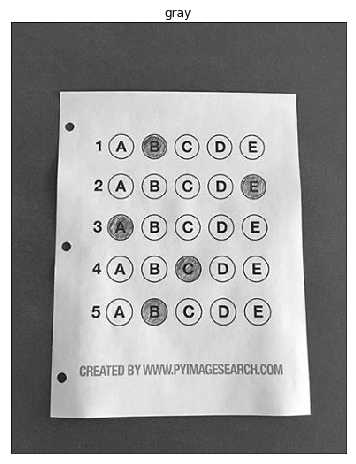

In [3]:
# define the answer key which maps the question numbers
# to the index of the correct bubble
ANSWER_KEY = {0: 1, 1: 4, 2: 0, 3: 3, 4: 1}

image = cv2.imread('origin.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
display1(gray, 'gray')

In [4]:
# reduce high frequency noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# find the edges/outlines with Canny edge detector
edged = auto_canny(gray) # (75, 200)

<img src='images/edged.png' width=35% align='left'>

In [5]:
# find contours in the edge map, then initialize
# the contour that corresponds to the document
(_, cnts, _) = cv2.findContours(edged.copy(),
                        cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE)
docCnt = None

# ensure that at least one contour was found
if len(cnts) > 0:
    # sort the contours according to their size in descending order
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

    # loop over the sorted contours
    for c in cnts:
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        # if our approximated contour has four points,
        # then we can assume we have found the paper
        if len(approx) == 4:
            docCnt = approx
            break

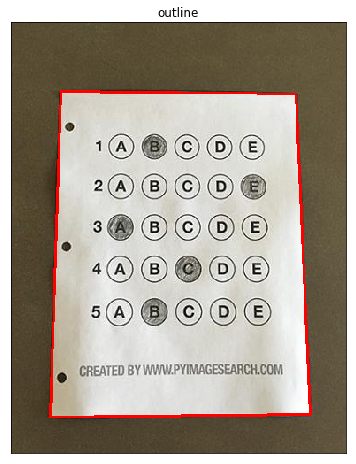

In [6]:
# show the contour (outline) of the piece of paper
imgcopy = image.copy()
cv2.drawContours(imgcopy, [docCnt], -1, (0, 0, 255), 2)
display1(imgcopy, 'outline', isGray=False)

### step 2: Apply a perspective transform to extract the top-down, birds-eye-view of the exam

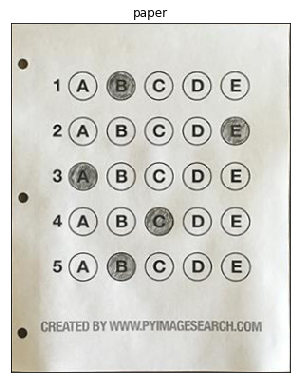

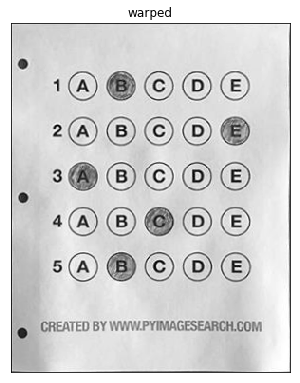

In [7]:
# apply a four point perspective transform to both the original image
# and grayscale image to obtain a top-down birds eye view of the paper
paper = four_point_transform(image, docCnt.reshape(4, 2))
warped = four_point_transform(gray, docCnt.reshape(4, 2))

display1(paper, 'paper', isGray=False, size=(5,7))
display1(warped, 'warped', size=(5,7))

### step 3: Extract the set of bubbles from the perspective transformed exam

Applying Otsu’s thresholding method to binarize the warped piece of paper, get a binary image. Binarizationis is the process of thresholding/segmenting the foreground from the background of the image.

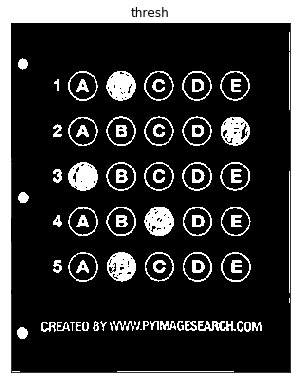

In [11]:
thresh = cv2.threshold(warped, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

# 自适应二值化算法
# thresh = cv2.adaptiveThreshold(warped, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 131, 4)

display1(thresh, 'thresh', size=(5,7))

Apply contour extraction techniques to find each of the bubbles in the exam.

In [10]:
# find contours in the thresholded image, then initialize
# the list of contours that correspond to questions/bubbles
(_, cnts, _) = cv2.findContours(thresh.copy(),
                        cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE)
# cnts = imutils.grab_contours(cnts)
questionCnts = []

# loop over the contours
for c in cnts:
    # compute the bounding box of the contour, then use the
    # bounding box to derive the aspect ratio
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)

    # in order to label the contour as a question, region
    # should be sufficiently wide, sufficiently tall, and
    # have an aspect ratio approximately equal to 1
    if w >= 20 and h >= 20 and ar >= 0.9 and ar <= 1.1:
        questionCnts.append(c)

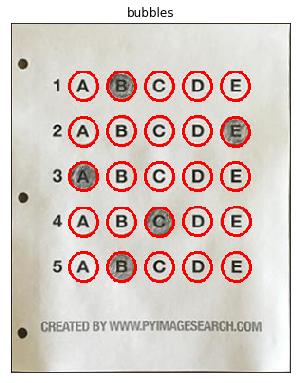

In [11]:
papcopy = paper.copy()

for cnt in questionCnts:
    (x, y, w, h) = cv2.boundingRect(cnt)
    # 2 center 3 radius 4 color 5 line w
    cv2.circle(papcopy, (x+w//2,y+h//2), (w+h)//4, (0, 0, 255), 2)

display1(papcopy, 'bubbles', isGray=False, size=(5,7))

### step 4: Sort the questions/bubbles into rows

Now move on to the “grading” portion of our OMR system.

By sorting our contours from top-to-bottom, followed by left-to-right, we can extract each row of bubbles. Therefore, each row is equal to the bubbles for one question.

In [12]:
# sort the question contours top-to-bottom. ensure that rows of questions that
# are closer to the top of the exam will appear first in the sorted list.

questionCnts = contours.sort_contours(questionCnts,
    method="top-to-bottom")[0]

# each question has 5 possible answers, to loop over the
# question in batches of 5
row_cnts = []
for (q, i) in enumerate(np.arange(0, len(questionCnts), 5)):
    # sort the contours for the current question from left
    # to right, then initialize the index of the bubbled answer
    cnts = contours.sort_contours(questionCnts[i:i + 5])[0]
    row_cnts.append(cnts)

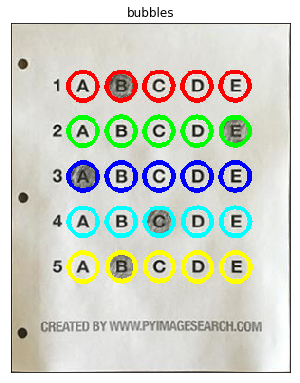

In [13]:
papcopy = paper.copy()

color = [(0,0,255), (0,255,0), (255,0,0), (255,255,0), (0,255,255)]

for i, cnts in enumerate(row_cnts):
    for cnt in cnts:
        cv2.drawContours(papcopy, [cnt], -1, color[i], 3)

display1(papcopy, 'bubbles', isGray=False, size=(5,7))

### step 5: Determine the marked answer for each row

### step 6: Lookup the correct answer in answer key to determine if the user was correct in their choice

Given a row of bubbles, determine which bubble is filled in by using `thresh` image and counting the number of non-zero pixels (i.e., foreground pixels) in each bubble region.

The bubble with the maximum non-zero count is the index of the bubble that the the test taker has bubbled in.

<img src='images/omr_mask.gif' width=30% align='left'>

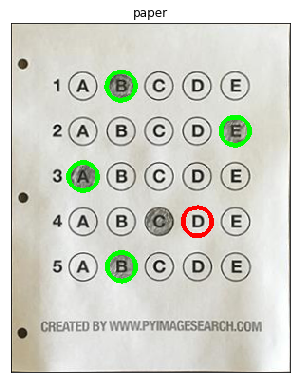

In [14]:
# the total number of correct answers
correct = 0

for q, cnts in enumerate(row_cnts):
    bubbled = None
    # loop over the sorted contours
    for (j, c) in enumerate(cnts):
        # construct a mask that reveals only the current
        # "bubble" for the question
        mask = np.zeros(thresh.shape, dtype="uint8")
        # 255表示白色，第二个-1表示填充
        cv2.drawContours(mask, [c], -1, 255, -1)

        # apply the mask to the thresholded image, then count
        # the number of non-zero pixels in the bubble area
        mask = cv2.bitwise_and(thresh, thresh, mask=mask)
        total = cv2.countNonZero(mask)

        # if the current total has a larger number of total non-zero
        # pixels, then examining the currently bubbled-in answer
        if bubbled is None or total > bubbled[0]:
            bubbled = (total, j)

    # the index of correct answer
    k = ANSWER_KEY[q]

    # check to see if the bubbled answer is correct
    if k == bubbled[1]:
        color = (0, 255, 0) # green
        correct += 1
    else:
        color = (0, 0, 255) # red

    # draw the outline of the correct answer on the test
    cv2.drawContours(paper, [cnts[k]], -1, color, 3)

display1(paper, 'paper', isGray=False, size=(5,7))

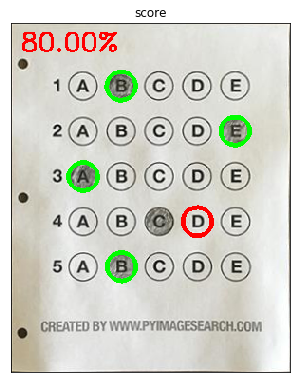

In [16]:
# scoring the exam and display the results
score = (correct / 5.0) * 100
cv2.putText(paper, "{:.2f}%".format(score), (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

display1(paper, 'score', isGray=False, size=(5,7))

### Why not use circle detection?

After going through this tutorial, you might be wondering:

*“Hey Adrian, an answer bubble is a circle. So why did you extract contours instead of applying [Hough circles](https://www.pyimagesearch.com/2014/07/21/detecting-circles-images-using-opencv-hough-circles/) to find the circles in the image?”*

Great question.

To start, tuning the parameters to Hough circles on an image-to-image basis can be a real pain. But that’s only a minor reason.

The real reason is: **User error**.

How many times, whether purposely or not, have you filled in outside the lines on your bubble sheet? I’m not expert, but I’d have to guess that at least 1 in every 20 marks a test taker fills in is “slightly” outside the lines.

And guess what?

Hough circles don’t handle deformations in their outlines very well — your circle detection would totally fail in that case.

Because of this, I instead recommend using contours and contour properties to help you filter the bubbles and answers. The `cv2.findContours` function doesn’t care if the bubble is “round”, “perfectly round”, or “oh my god, what the hell is that?”.

Instead, the `cv2.findContours` function will return a set of blobs to you, which will be the foreground regions in your image. You can then take these regions process and filter them to find your questions (as we did in this tutorial), and go about your way.

### Extending the OMR and test scanner

While I was able to get the barebones of a working bubble sheet test scanner implemented, there are certainly a few areas that need improvement. The most obvious area for improvement is the logic to handle non-filled in bubbles.

In the current implementation, we (naively) assume that a reader has filled in one and only one bubble per question row.

However, since we determine if a particular bubble is “filled in” simply by counting the number of thresholded pixels in a row and then sorting in descending order, this can lead to two problems:

1. What happens if a user does not bubble in an answer for a particular question?
2. What if the user is nefarious and marks multiple bubbles as “correct” in the same row?

<img src='images/omr_no_bubbles.jpg' width=30%>  

<img src='images/omr_multiple_bubbles.jpg' width=30%>

Luckily, detecting and handling of these issues isn’t terribly challenging, we just need to insert a bit of logic.

For issue #1, if a reader chooses not to bubble in an answer for a particular row, then we can place a minimum threshold on  where we compute cv2.countNonZero.

If this value is sufficiently large, then we can mark the bubble as “filled in”. Conversely, if `total` is too small, then we can skip that particular bubble. If at the end of the row there are no bubbles with sufficiently large threshold counts, we can mark the question as “skipped” by the test taker.

A similar set of steps can be applied to issue #2, where a user marks multiple bubbles as correct for a single question.

Again, all we need to do is apply our thresholding and count step, this time keeping track if there are multiple bubbles that have a total  that exceeds some pre-defined value. If so, we can invalidate the question and mark the question as incorrect.

### Summary

In this blog post, I demonstrated how to build a bubble sheet scanner and test grader using computer vision and image processing techniques.

Specifically, we implemented Optical Mark Recognition (OMR) methods that facilitated our ability of capturing human-marked documents and automatically analyzing the results.